In [2]:
import numpy as np 
from numpy import argmax
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker 
from matplotlib.ticker import ScalarFormatter 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, brier_score_loss, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import datetime
from sklearn.pipeline import Pipeline

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 0. Import Data

In [3]:
data = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')

# 1. Data Preprocessing

In [4]:
#Average time delta between transactions !not used in calculations
def list_diff(x_input):
    if len(x_input)<2:
        xdiff = 0
        delta_mean=0
    else:
        xdiff = [x_input[n]-x_input[n-1] for n in range(1,len(x_input))]
        delta_mean = np.mean(xdiff)
    return delta_mean
    
#Delta before last transaction !not used in calculations
def delta_last(x_input):
    if len(x_input)<2:
        delta_l=0
    else:
        delta_l = x_input[-1]-x_input[-2]
    return delta_l

def data_preprocessing(data):
    #number of transactions Orig !not used in calculations
    dict_count_sent = data['nameOrig'].value_counts()
    data['New_TotalOrig']= data['nameOrig'].map(dict_count_sent) 
    
    #number of transactions Dest !not used in calculations
    dict_count_get = data['nameDest'].value_counts()
    data['New_TotalDest']= data['nameDest'].map(dict_count_get)
    
    #average transaction Orig !not used in calculations
    trans_mean_orig = data.groupby("nameOrig")["amount"].aggregate(['mean'])
    dict_trans_mean_orig=trans_mean_orig.to_dict()
    value_dict_trans_mean_orig=dict_trans_mean_orig['mean']
    data['New_TotalMeanOrig']=data['nameOrig'].map(value_dict_trans_mean_orig)
    
    #average transaction Dest !not used in calculations
    trans_mean_dest = data.groupby("nameDest")["amount"].aggregate(['mean'])
    dict_trans_mean_dest=trans_mean_dest.to_dict()
    value_dict_trans_mean_dest=dict_trans_mean_dest['mean']
    data['New_TotalMeanDest']=data['nameDest'].map(value_dict_trans_mean_dest)
    
    #Amount of transactions with participation Orig !not used in calculations
    trans_sum_orig = data.groupby("nameOrig")["amount"].aggregate([sum])
    dict_trans_sum_orig=trans_sum_orig.to_dict()
    value_dict_trans_sum_orig=dict_trans_sum_orig['sum']
    data['New_TotalSumOrig']=data['nameOrig'].map(value_dict_trans_sum_orig)
    
    #Amount of transactions with participation Dest !not used in calculations
    trans_sum_dest = data.groupby("nameDest")["amount"].aggregate([sum])
    dict_trans_sum_dest=trans_sum_dest.to_dict()
    value_dict_trans_sum_dest=dict_trans_sum_dest['sum']
    data['New_TotalSumDest']=data['nameDest'].map(value_dict_trans_sum_dest)
    
    #type Orig ==first letter from nameOrig 
    data['New_TypeOrig']= data['nameOrig'].apply(lambda x: x[0])
    
    #type Dest ==first letter from nameDest
    data['New_TypeDest']= data['nameDest'].apply(lambda x: x[0])
    
    #Average time delta between transactions Orig !not used in calculations
    x_input = data.groupby('nameOrig')['step'].apply(list).reset_index(name='info')
    data = pd.merge(data, x_input, how='left', on='nameOrig')
    data['New_Delta_Time_Tr_Orig'] = data['info'].apply(lambda x: list_diff(x))
    #time to previous transaction Orig !not used in calculations
    data['New_Delta_Last_Tr_Orig']= data['info'].apply(lambda x: delta_last(x))
    
    #Average time delta between transactions Dest !not used in calculations
    x_input_dest = data.groupby('nameDest')['step'].apply(list).reset_index(name='info_2')
    data = pd.merge(data, x_input_dest, how='left', on='nameDest')
    data['New_Delta_Time_Tr_Dest'] = data['info_2'].apply(lambda x: list_diff(x) )
    #time to previous transaction Dest !not used in calculations
    data['New_Delta_Last_Tr_Dest']= data['info_2'].apply(lambda x: delta_last(x))
    
    #Removing extra columns
    data = data.drop(columns=['info','info_2'])
    
    #delete first letter Orig , Dest
    data['nameOrig']=data['nameOrig'].apply(lambda x: x[1:])
    data['nameDest']=data['nameDest'].apply(lambda x: x[1:])
    
    #!not used in calculations
    data['res_data']=pd.to_datetime(data['step'], unit='h', origin=pd.Timestamp('2000-01-01'))
    
    ### Select the date, days of the week, hours, month  !not used in calculations
    data['date'] = data.res_data.dt.date
    data['day_of_week'] = data.res_data.dt.dayofweek
    data['hour'] = data.res_data.dt.hour
    data['month'] = data.res_data.dt.month
    
    return data
        

In [5]:
data_f = data_preprocessing(data)
data_f

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,New_TypeDest,New_Delta_Time_Tr_Orig,New_Delta_Last_Tr_Orig,New_Delta_Time_Tr_Dest,New_Delta_Last_Tr_Dest,res_data,date,day_of_week,hour,month
0,1,PAYMENT,9839.64,1231006815,170136.00,160296.36,1979787155,0.00,0.00,0,...,M,0.0,0,0.000000,0,2000-01-01 01:00:00,2000-01-01,5,1,1
1,1,PAYMENT,1864.28,1666544295,21249.00,19384.72,2044282225,0.00,0.00,0,...,M,0.0,0,0.000000,0,2000-01-01 01:00:00,2000-01-01,5,1,1
2,1,TRANSFER,181.00,1305486145,181.00,0.00,553264065,0.00,0.00,1,...,C,0.0,0,9.279070,20,2000-01-01 01:00:00,2000-01-01,5,1,1
3,1,CASH_OUT,181.00,840083671,181.00,0.00,38997010,21182.00,0.00,1,...,C,0.0,0,13.575000,144,2000-01-01 01:00:00,2000-01-01,5,1,1
4,1,PAYMENT,11668.14,2048537720,41554.00,29885.86,1230701703,0.00,0.00,0,...,M,0.0,0,0.000000,0,2000-01-01 01:00:00,2000-01-01,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,786484425,339682.13,0.00,776919290,0.00,339682.13,1,...,C,0.0,0,465.000000,465,2000-01-31 23:00:00,2000-01-31,0,23,1
6362616,743,TRANSFER,6311409.28,1529008245,6311409.28,0.00,1881841831,0.00,0.00,1,...,C,0.0,0,0.000000,0,2000-01-31 23:00:00,2000-01-31,0,23,1
6362617,743,CASH_OUT,6311409.28,1162922333,6311409.28,0.00,1365125890,68488.84,6379898.11,1,...,C,0.0,0,268.500000,489,2000-01-31 23:00:00,2000-01-31,0,23,1
6362618,743,TRANSFER,850002.52,1685995037,850002.52,0.00,2080388513,0.00,0.00,1,...,C,0.0,0,0.000000,0,2000-01-31 23:00:00,2000-01-31,0,23,1


In [6]:
data_f.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'New_TotalOrig', 'New_TotalDest', 'New_TotalMeanOrig',
       'New_TotalMeanDest', 'New_TotalSumOrig', 'New_TotalSumDest',
       'New_TypeOrig', 'New_TypeDest', 'New_Delta_Time_Tr_Orig',
       'New_Delta_Last_Tr_Orig', 'New_Delta_Time_Tr_Dest',
       'New_Delta_Last_Tr_Dest', 'res_data', 'date', 'day_of_week', 'hour',
       'month'],
      dtype='object')

# 2. EDA

let's сheck if there are duplicates in the data

In [7]:
print('Number of duplicates are : ', data_f.duplicated().sum())

Number of duplicates are :  0


let's check for gaps in the data

In [8]:
data_f.isnull().sum()

step                      0
type                      0
amount                    0
nameOrig                  0
oldbalanceOrg             0
newbalanceOrig            0
nameDest                  0
oldbalanceDest            0
newbalanceDest            0
isFraud                   0
isFlaggedFraud            0
New_TotalOrig             0
New_TotalDest             0
New_TotalMeanOrig         0
New_TotalMeanDest         0
New_TotalSumOrig          0
New_TotalSumDest          0
New_TypeOrig              0
New_TypeDest              0
New_Delta_Time_Tr_Orig    0
New_Delta_Last_Tr_Orig    0
New_Delta_Time_Tr_Dest    0
New_Delta_Last_Tr_Dest    0
res_data                  0
date                      0
day_of_week               0
hour                      0
month                     0
dtype: int64

let's plot Correlation Matrix 

/tmp/ipykernel_34/4257904808.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(data_h.corr(), dtype=np.bool))
/tmp/ipykernel_34/4257904808.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(data_h.corr(), dtype=np.bool))
/tmp/ipykernel_34/4257904808.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_

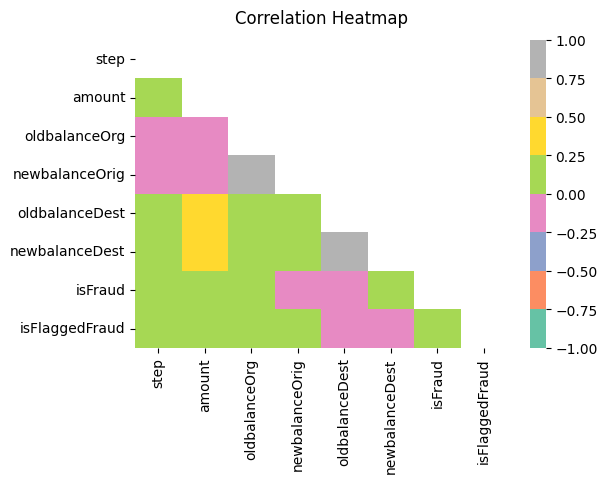

In [9]:
def heatmap_eda(data):
    data_h = data[['step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']]
    
    plt.figure(figsize=(6, 4))
    mask = np.triu(np.ones_like(data_h.corr(), dtype=np.bool))
    heatmap = sns.heatmap(data_h.corr(), mask=mask, vmin=-1, vmax=1, center=0, annot=False, cmap="Set2")
    heatmap.set_title('Correlation Heatmap', pad=12)

heatmap_eda(data_f)

Let's make a barplot to see the fraud and non fraud transactions in different transactions type

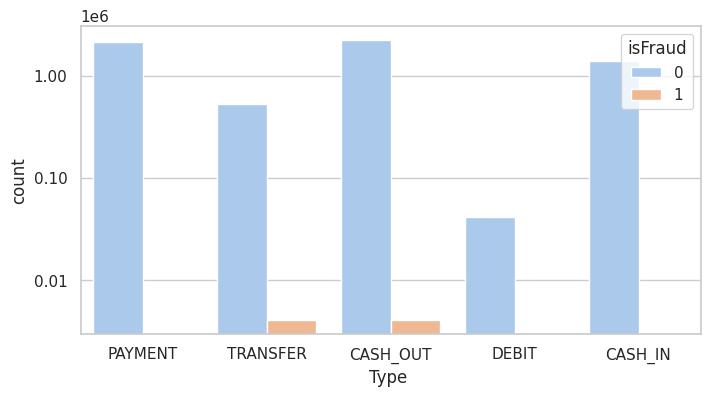

In [10]:
def countplot_eda(data_f):
    sns.set_style('whitegrid')
    sns.set_context('notebook')
    plt.figure(figsize=(8, 4))
    counplot = sns.countplot(data=data_f, x='type', hue='isFraud',palette= "pastel")
    counplot.set_xlabel('Type ')
    counplot.set_ylabel(f'count')
    counplot.set_yscale('log')
    counplot.yaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.show()

countplot_eda(data_f)

* As we can see, fraud transactions are done in TRANSFER and CASH_OUT transaction type.

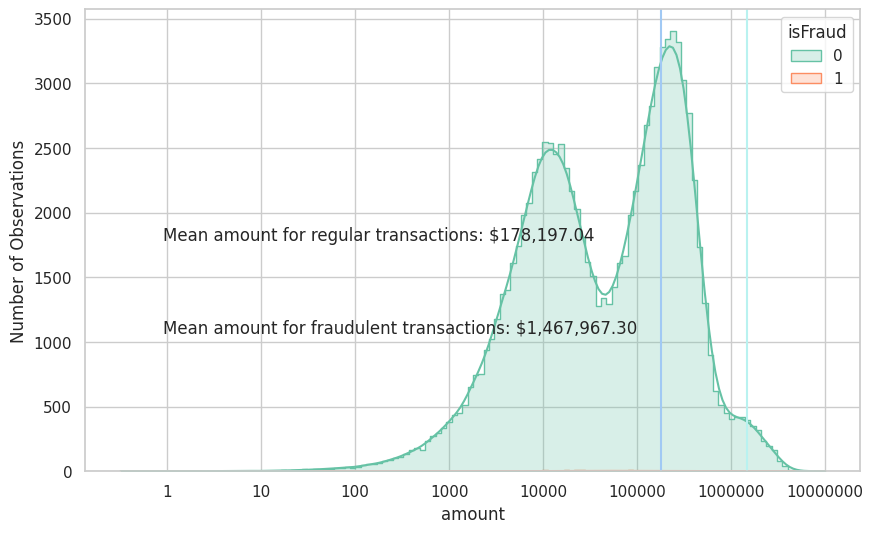

In [11]:
def histplot_eda(data):
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("pastel")
    histplot = sns.histplot(data=data[:100000], 
                            x='amount', 
                            hue='isFraud', 
                            kde=True, 
                            element='step', 
                            palette= "Set2", 
                            log_scale=True)
    histplot.set_ylabel('Number of Observations')
    histplot.set_xlabel(f'amount')
    mean_value_f = data[data['isFraud']==False]['amount'].mean()
    mean_value_t = data[data['isFraud']==True]['amount'].mean()
    histplot.axvline(x=mean_value_f, color=palette[0])
    histplot.axvline(x=mean_value_t, color=palette[-1])
    histplot.annotate(f'Mean amount for regular transactions: ${mean_value_f:,.2f}', 
                      xy=(0.1, 0.5),
                      xycoords='axes fraction')
    histplot.annotate(f'Mean amount for fraudulent transactions: ${mean_value_t:,.2f}', 
                      xy=(0.1, 0.3),
                      xycoords='axes fraction')
    histplot.xaxis.set_major_formatter(mticker.ScalarFormatter())
    histplot.ticklabel_format(style='plain', 
                              axis='x')  
    plt.show()
    
histplot_eda(data_f)

* As we can see, the transaction amount is significantly higher for fraud transactions.

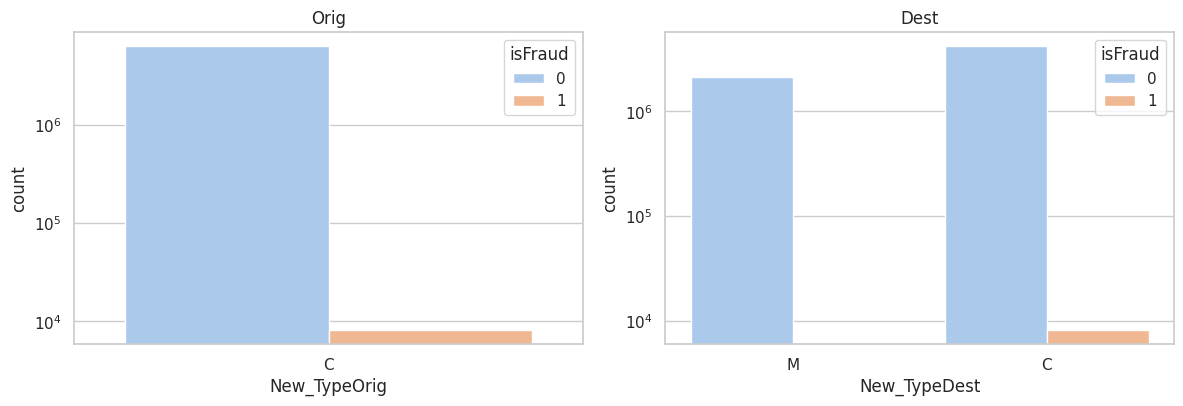

In [12]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax_1 = fig.add_subplot(1, 2, 1)
sns.countplot(data=data_f, 
              x='New_TypeOrig', 
              hue='isFraud',
              palette= "pastel").set_yscale('log')
ax_2 = fig.add_subplot(1, 2, 2)
sns.countplot(data=data_f, 
              x='New_TypeDest', 
              hue='isFraud',
              palette= "pastel").set_yscale('log')
fig.tight_layout()
ax_1.set(title = 'Orig')
ax_2.set(title = 'Dest')
plt.show()

**Let's see how transactions are distributed over time**

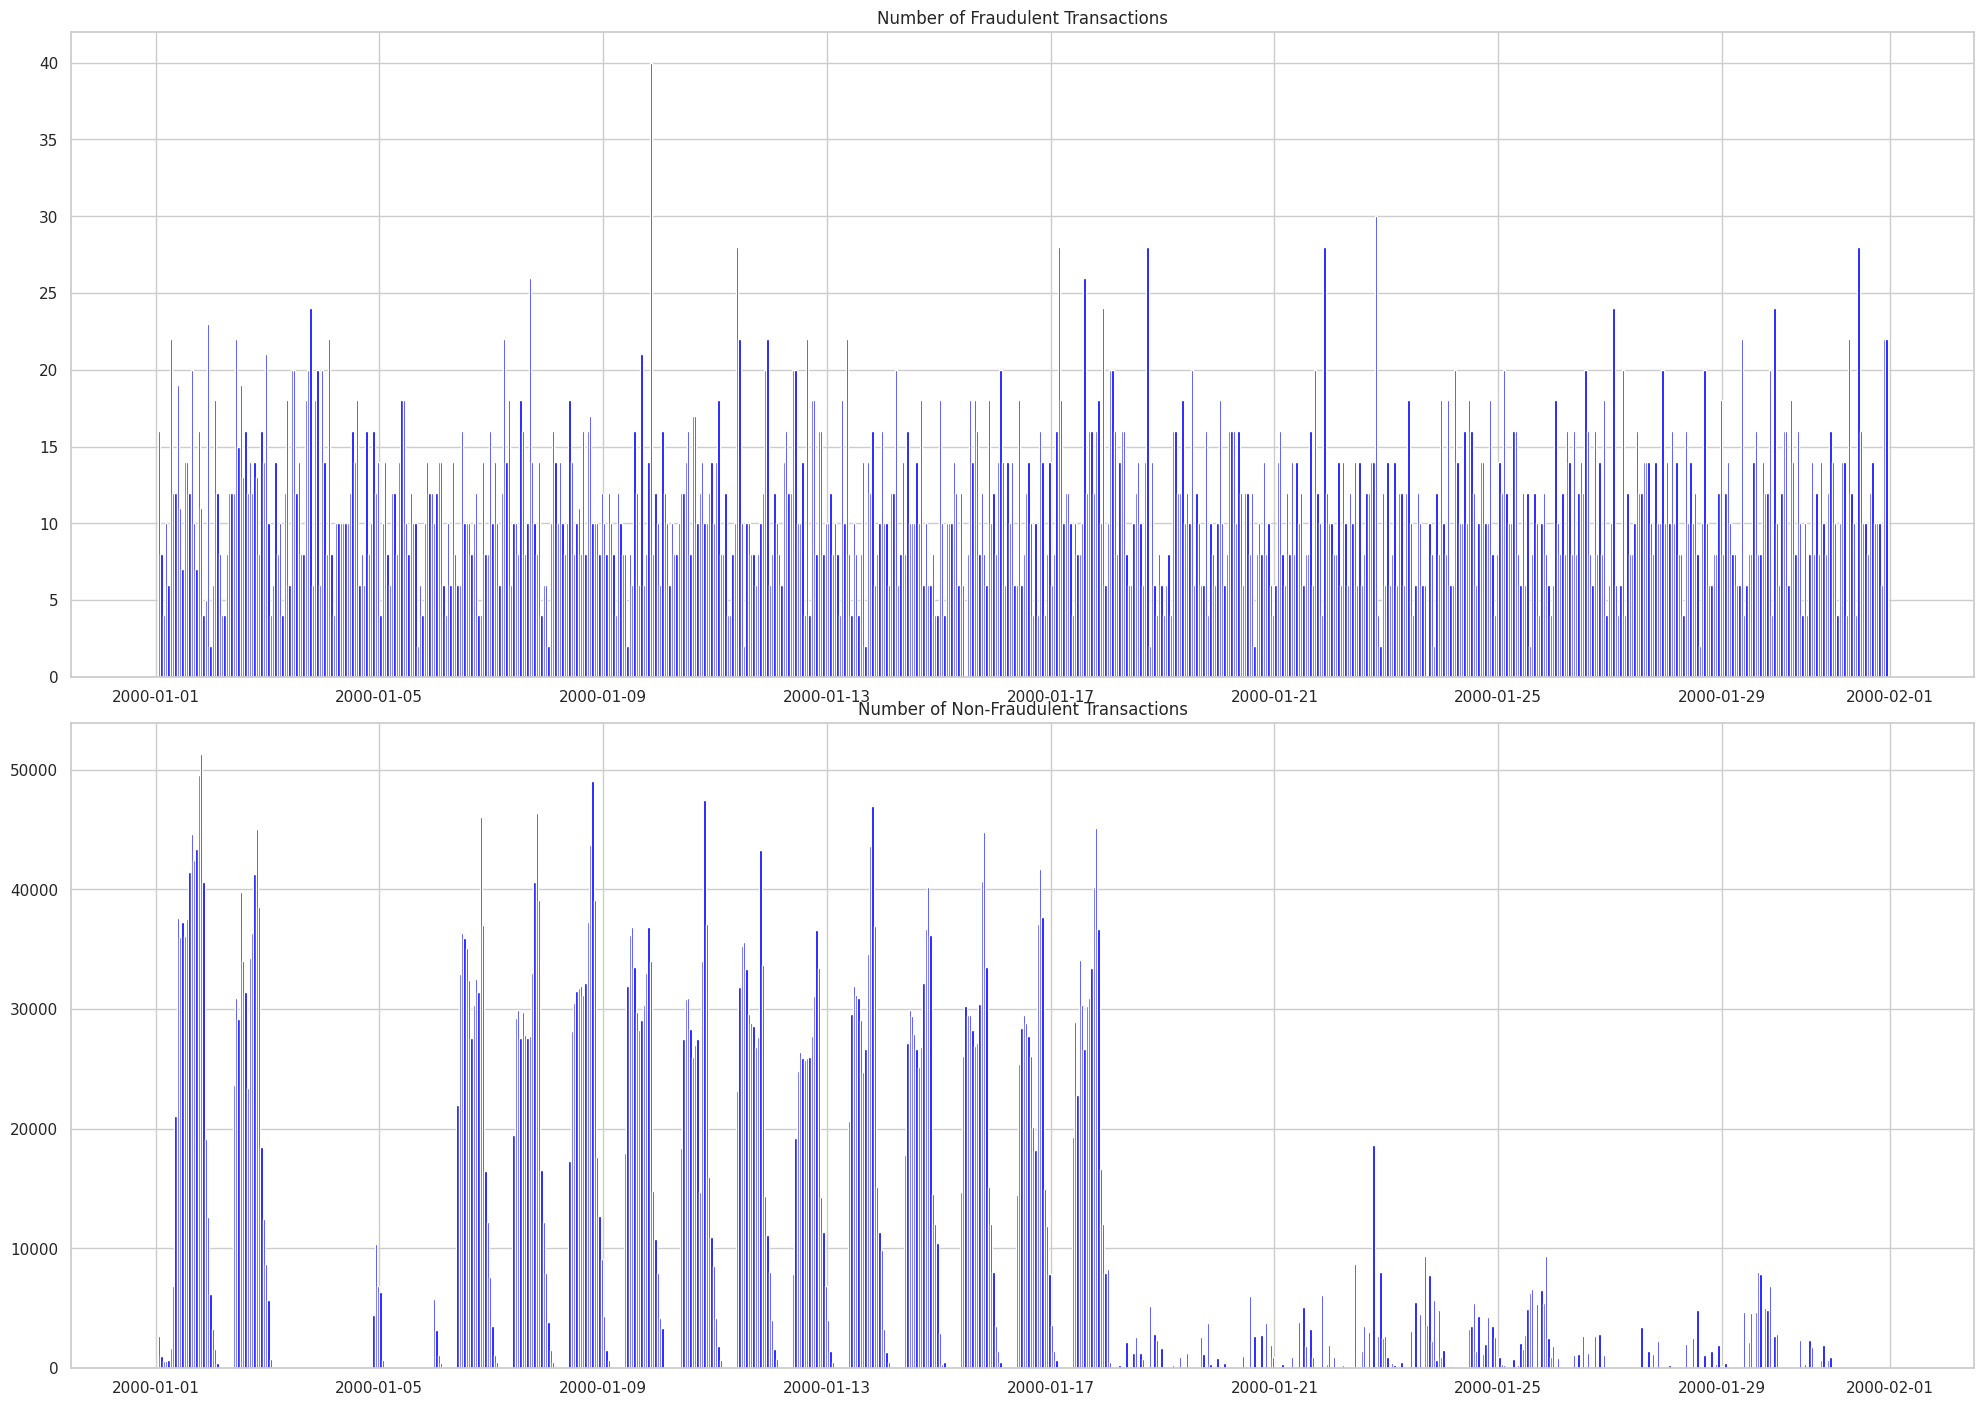

In [13]:
fig = plt.figure()
fig.set_size_inches(20, 14)
ax_1 = fig.add_subplot(2, 1, 1)
plt.hist(data_f[data_f['isFraud']==1]['res_data'], 
         bins=data_f['res_data'].unique(), 
         color = "blue")
ax_2 = fig.add_subplot(2, 1, 2)
plt.hist(data_f[data_f['isFraud']==0]['res_data'], 
         bins=data_f['res_data'].unique(),
         color = "blue")
fig.tight_layout()
ax_1.set(title = 'Number of Fraudulent Transactions')
ax_2.set(title = 'Number of Non-Fraudulent Transactions')
plt.show()

* How we can notice fraudulent transactions are distributed evenly over time, while regular transactions exhibit a certain pattern

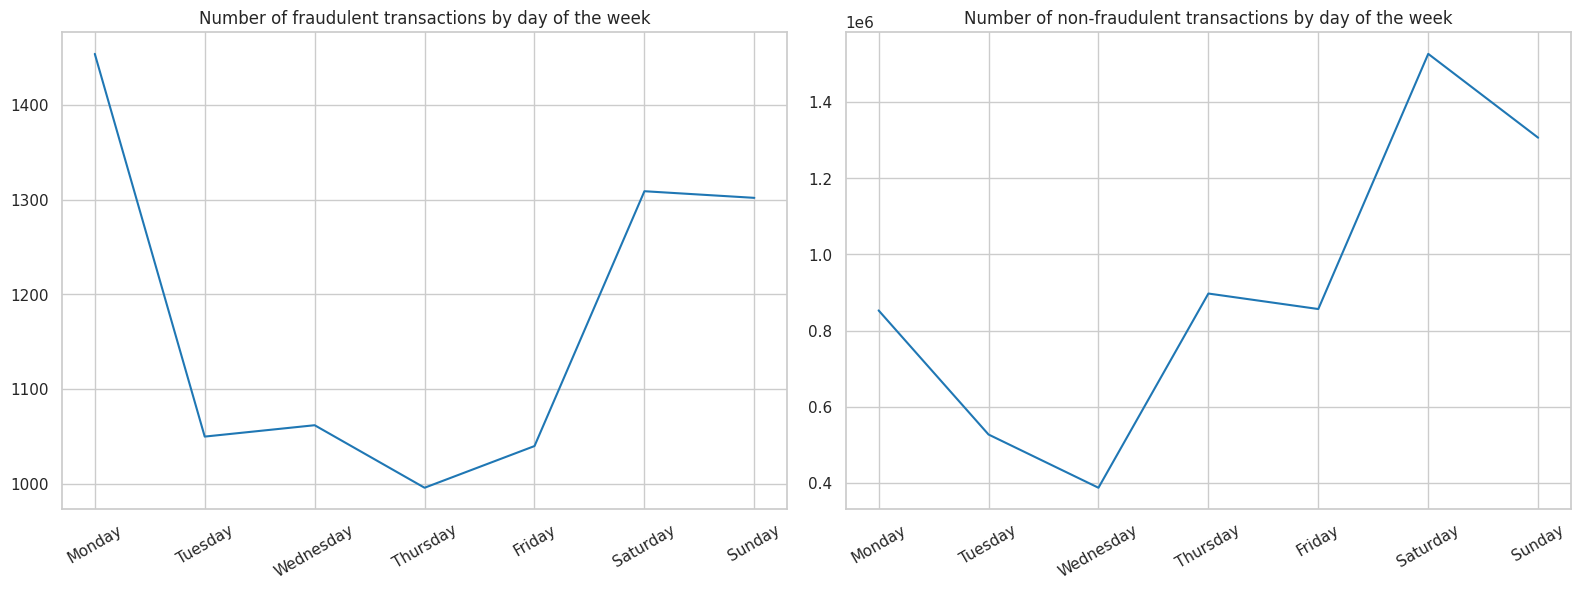

In [14]:
fig = plt.figure()
fig.set_size_inches(16, 6)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(data_f[data_f['isFraud']==1].groupby(['day_of_week']).size())
plt.xticks(range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
           rotation=30)

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(data_f[data_f['isFraud']==0].groupby(['day_of_week']).size())
plt.xticks(range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
           rotation=30)

fig.tight_layout()
ax_1.set(title = 'Number of fraudulent transactions by day of the week')
ax_2.set(title = 'Number of non-fraudulent transactions by day of the week')
plt.show()

* We see the maximum number of fraudulent transactions on Monday and minimum number of fraudulent transactions on Thursday
* We see the maximum number of non-fraudulent transactions on Saturday and minimum number of fraudulent transactions on Wednesday

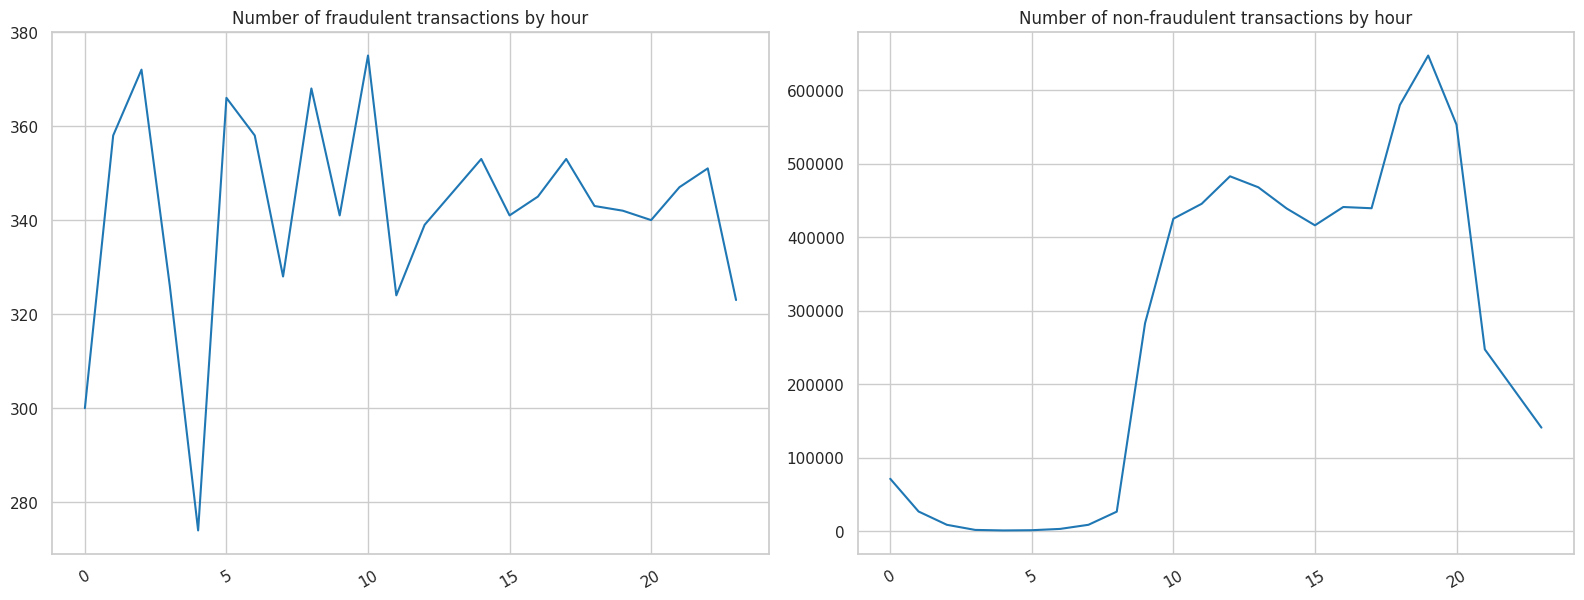

In [15]:
fig = plt.figure()
fig.set_size_inches(16, 6)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(data_f[data_f['isFraud']==1].groupby(['hour']).size())
plt.xticks(rotation=30)

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(data_f[data_f['isFraud']==0].groupby(['hour']).size())
plt.xticks(rotation=30)

fig.tight_layout()
ax_1.set(title = 'Number of fraudulent transactions by hour')
ax_2.set(title = 'Number of non-fraudulent transactions by hour')
plt.show()

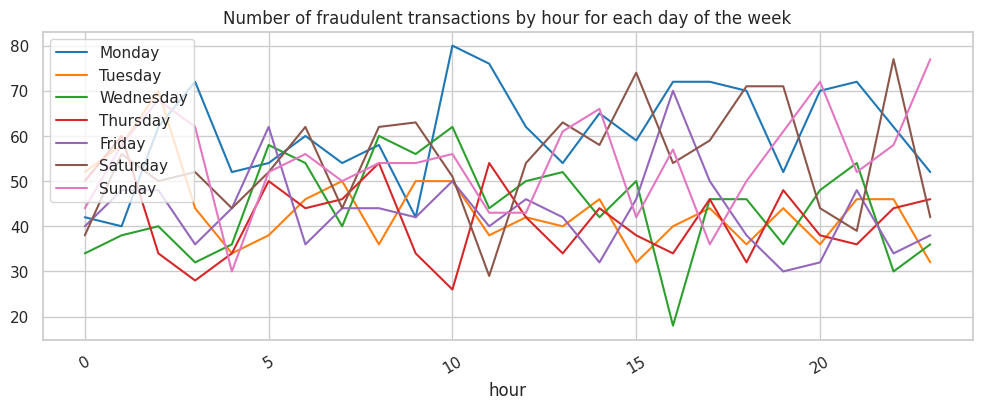

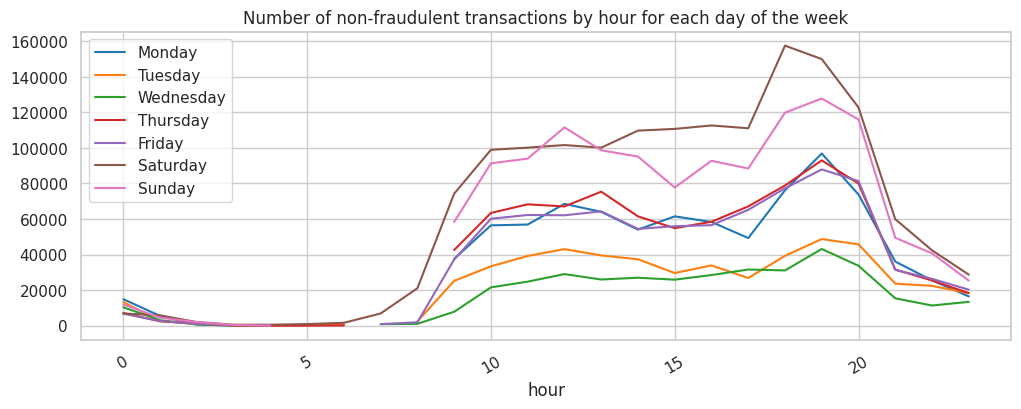

In [16]:
### Let's build average target curves by hours for each day of the week
frame1 = data_f[data_f['isFraud']==1].groupby(['day_of_week', 'hour'], as_index=False)['amount'].count()
frame1 = frame1.pivot(index='hour', columns='day_of_week', values='amount')
frame1.plot(figsize=(12, 4),color=['#1f77b4', '#ff7f0e', '#2ca02c', 
                                   '#d62728', '#9467bd','#8c564b', '#e377c2'])
plt.xticks(rotation=30)
plt.title('Number of fraudulent transactions by hour for each day of the week')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

frame2 = data_f[data_f['isFraud']==0].groupby(['day_of_week', 'hour'], as_index=False)['amount'].count()
frame2 = frame2.pivot(index='hour', columns='day_of_week', values='amount')
frame2.plot(figsize=(12, 4),color=['#1f77b4', '#ff7f0e', '#2ca02c', 
                                   '#d62728', '#9467bd','#8c564b', '#e377c2'])
plt.xticks(rotation=30)
plt.title('Number of non-fraudulent transactions by hour for each day of the week')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()

* It can be seen that the peak almost always falls at the same time on almost any day of the week, around 17-20 hours.

# 3. Data preparation

In [18]:
data_test = data_f.copy()
#Let's leave only the necessary columns
data_test.drop(columns = ['step', 'nameOrig','nameDest', 'isFlaggedFraud', 
                          'New_TotalOrig', 'New_TotalDest', 'New_TotalMeanOrig',
                          'New_TotalMeanDest', 'New_TotalSumOrig', 'New_TotalSumDest', 
                          'New_Delta_Time_Tr_Orig','New_Delta_Last_Tr_Orig', 
                          'New_Delta_Time_Tr_Dest','New_Delta_Last_Tr_Dest', 
                          'res_data', 'date', 'day_of_week', 'hour','month'], 
               inplace=True)

In [19]:
data_test

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,New_TypeOrig,New_TypeDest
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,C,M
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,C,M
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,C,C
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,C,C
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,C,M
...,...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,C,C
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,C,C
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,C,C
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,C,C


**Categorical Features**

In [20]:
print(data_test.dtypes)

type               object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
New_TypeOrig       object
New_TypeDest       object
dtype: object


In [21]:
#due to the fact that we have few unique values, we will go by the simple way of converting categorical features
data_test = pd.get_dummies(data_test, prefix = ['type', 'New_TypeOrig', 'New_TypeDest'], drop_first = True)

In [22]:
data_test

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,New_TypeDest_M
0,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,1,0,1
1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,1,0,1
2,181.00,181.00,0.00,0.00,0.00,1,0,0,0,1,0
3,181.00,181.00,0.00,21182.00,0.00,1,1,0,0,0,0
4,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13,1,1,0,0,0,0
6362616,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0,0,1,0
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,1,0,0,0,0
6362618,850002.52,850002.52,0.00,0.00,0.00,1,0,0,0,1,0


# 4. Test Launch

let's try to run a test model (LogisticRegression) without special data preparation, only after pre-processing categorical features

In [23]:
X = data_test.drop(columns=['isFraud'])
y = data_test['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=42)

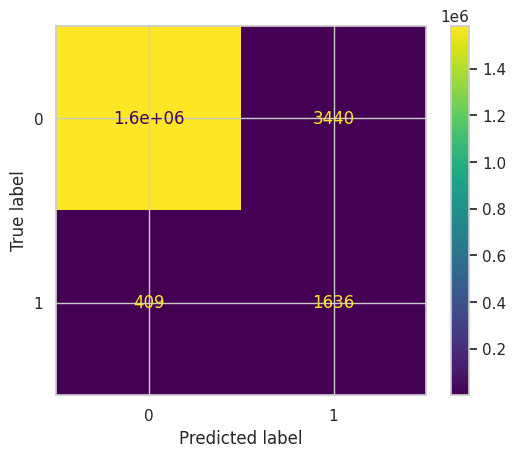

In [24]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train,y_train)
lr_prediction=lr_model.predict(X_test)
cm_lr = confusion_matrix(y_test, lr_prediction, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr_model.classes_)
disp.plot()
plt.show()

Try another one: CatBoost

Learning rate set to 0.5
0:	learn: 0.3142237	total: 482ms	remaining: 9.15s
1:	learn: 0.1727212	total: 779ms	remaining: 7.01s
2:	learn: 0.1001044	total: 1.1s	remaining: 6.23s
3:	learn: 0.0592021	total: 1.41s	remaining: 5.65s
4:	learn: 0.0359391	total: 1.71s	remaining: 5.13s
5:	learn: 0.0223190	total: 2.01s	remaining: 4.69s
6:	learn: 0.0142503	total: 2.32s	remaining: 4.3s
7:	learn: 0.0093745	total: 2.62s	remaining: 3.94s
8:	learn: 0.0065300	total: 2.93s	remaining: 3.58s
9:	learn: 0.0048296	total: 3.27s	remaining: 3.27s
10:	learn: 0.0036883	total: 3.6s	remaining: 2.95s
11:	learn: 0.0029723	total: 3.92s	remaining: 2.61s
12:	learn: 0.0025032	total: 4.23s	remaining: 2.28s
13:	learn: 0.0022512	total: 4.55s	remaining: 1.95s
14:	learn: 0.0020897	total: 4.86s	remaining: 1.62s
15:	learn: 0.0019099	total: 5.17s	remaining: 1.29s
16:	learn: 0.0018050	total: 5.5s	remaining: 970ms
17:	learn: 0.0017296	total: 5.91s	remaining: 656ms
18:	learn: 0.0016268	total: 6.37s	remaining: 335ms
19:	learn: 0.0015798

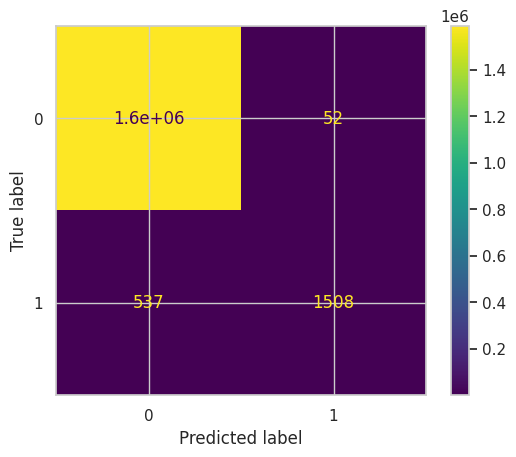

In [25]:
cbc_model = CatBoostClassifier(iterations=20,
                               loss_function='Logloss',
                               verbose=True)
cbc_model.fit(X_train, y_train)
cbc_prediction = cbc_model.predict(X_test)

cm_cbc = confusion_matrix(y_test, cbc_prediction, labels=cbc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cbc, display_labels=cbc_model.classes_)
disp.plot()
plt.show()

In [26]:
#Look at the ratio of classes in the target
print(sum(data_test['isFraud'] == 1), '- positive class')
print(sum(data_test['isFraud'] == 0), '- negative class')

8213 - positive class
6354407 - negative class


How we see that our models do not classify data well in positive classes that are critical for us.
Maybe the problem is that we have a strong class imbalance. Let's try to do something about it

# 5. Oversampling and Undersampling

**Class imbalance in classification**

There are two ways to balance classes - by increasing the smaller class with random duplication, or by decreasing the larger class by randomly removing observations.

**SMOTE | Overcoming Class Imbalance Problem Using SMOTE**

SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling.

In [27]:
over_sample = SMOTE(random_state=42)
X_train_sm, y_train_sm = over_sample.fit_resample(X_train,y_train)

In [28]:
print(sum(y_train_sm == 1), '- positive class')
print(sum(y_train_sm == 0), '- negative class')

4765797 - positive class
4765797 - negative class


let's try to run LogisticRegression with smote

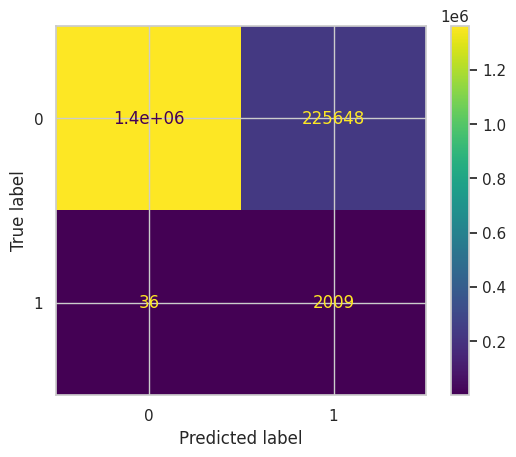

In [29]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_sm,y_train_sm)
lr_prediction=lr_model.predict(X_test)
cm_lr = confusion_matrix(y_test, lr_prediction, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr_model.classes_)
disp.plot()
plt.show()

Yes, it works! We will continue to use balanced data in calculations

# 6. Model Evaluation Metrics

!!!high cost associated with False Negative =>**Recall**

Let's say a customer requires that our classifier correctly predict fraud 60% of the time, so as not to bother 
customers due to false positive results.

How to solve this problem? => It is necessary to select a threshold that maximizes recall, provided that precision > 0.6.

**F1 score**
The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.

**Logarithmic Loss**
The Logarithmic Loss value - or simply the logloss - indicates how "confident" the classifier is in its prediction. Logloss returns the probability that an object belongs to a particular class, summing them up to give a general idea of ​​the "confidence" of the classifier. This indicator lies in the range from 0 to 1 - "not at all sure" and "completely sure", respectively. The logloss drops a lot when the classifier is strongly "sure" of the wrong answer

**Brier Score**
The Brier Score is a strictly proper score function or strictly proper scoring rule that measures the accuracy of probabilistic predictions. For unidimensional predictions, it is strictly equivalent to the mean squared error as applied to predicted probabilities.

**PR curve**
The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

**Confusion Matrix**
An confusion matrix is a table or chart showing the accuracy of a classifier's predictions with respect to
two or more classes. The classifier predictions are on the x-axis and the result (accuracy) is on the y-axis.
The cells of the table are filled with the number of classifier predictions. Correct predictions go diagonally from top left to bottom right.


In [30]:
def metrics_estimation(model, X_train_sm, X_test, y_train_sm, y_test, prediction, prob):
    #We build all kinds of combinations precision, recall, threshold
    precision, recall, thres = precision_recall_curve(y_test, prob[:, 1])
    #We find a triple for which recall is maximum and precision > 0.6
    ind = np.where(recall == recall[precision > 0.6].max())
    print(f"Precison score:\t {precision[ind][-1]}")
    print(f"Recall score: \t {recall[ind][-1]}")
    print(f"Threshold:\t {thres[ind][-1]}")

    # calculate f1_score for binary classification problem
    f1 = f1_score(y_test, prediction, average='binary')
    print('F1 score: %f' % (f1))

    # retrieve the probabilities for the positive class
    prob_positive = prob[:, 1]

    ###Log Loss Score
    logloss = log_loss(y_test, prob)
    print('Log Loss score: %f' % (logloss))

    ###Brier Score
    brier = brier_score_loss(y_test, prob_positive)
    print('Brier score: %f' % (brier))
    
    return (precision[ind][-1], recall[ind][-1], f1, logloss, brier, thres[ind][-1])


# 7. Test different models

**7.1.K-Nearest Neighbors**

The k nearest neighbors method calculates the distances from the new feature to all the features in the sample and, by selecting k nearest ones, predicts the target variable by voting (in the case of classification) or averaging (in the case of regression). \
At the same time, this method can be configured in different ways, for example, you can change the way distances are calculated or the way neighbors are weighted by distance.

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


In [31]:
scaler = StandardScaler()
Xsc_train = scaler.fit_transform(X_train_sm)
Xsc_test = scaler.transform(X_test)

In [32]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(Xsc_train, y_train_sm)
knn_prediction = knn_model.predict(Xsc_test)
knn_prob = knn_model.predict_proba(Xsc_test)

In [33]:
def metrics_estimation_for_knn(model, X_train_sm, X_test, y_train_sm, y_test, prediction, prob):
    #We build all kinds of combinations precision, recall, threshold
    precision, recall, thres = precision_recall_curve(y_test, prob[:, 1])
    #We find a triple for which recall is maximum and precision > 0.6
    ind = np.where(recall == recall[precision > 0.6].max())
    print(f"Precison score:\t {precision[ind][-1]}")
    print(f"Recall score: \t {recall[ind][-1]}")

    # calculate f1_score for binary classification problem
    f1 = f1_score(y_test, prediction, average='binary')
    print('F1 score: %f' % (f1))

    # retrieve the probabilities for the positive class
    prob_positive = prob[:, 1]

    ###Log Loss Score
    logloss = log_loss(y_test, prob)
    print('Log Loss score: %f' % (logloss))

    ###Brier Score
    brier = brier_score_loss(y_test, prob_positive)
    print('Brier score: %f' % (brier))
    
    return (precision[ind][-1], recall[ind][-1], f1, logloss, brier)

list_metrics_knn = metrics_estimation_for_knn(knn_model, Xsc_train, Xsc_test, y_train_sm, y_test, knn_prediction, knn_prob)

Precison score:	 1.0
Recall score: 	 0.0
F1 score: 0.383323
Log Loss score: 0.066912
Brier score: 0.002972


Area Under the Precision-Recall curve (PR AUC)

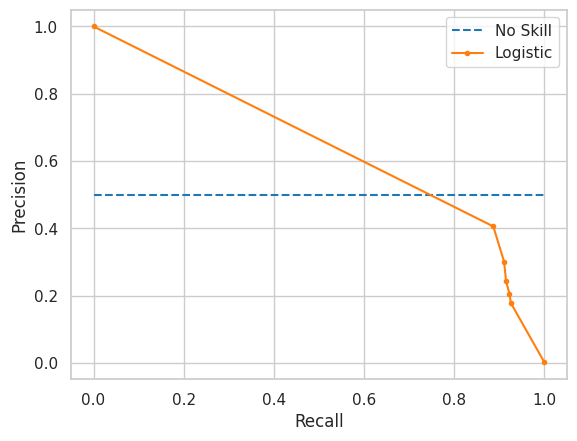

AUC PR: 0.642


In [34]:
# retrieve the probabilities for the positive class
knn_prob_positive = knn_prob[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = len((y_train_sm[y_train_sm==1])+(y_test[y_test==1])) / len(y_train_sm + y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, knn_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

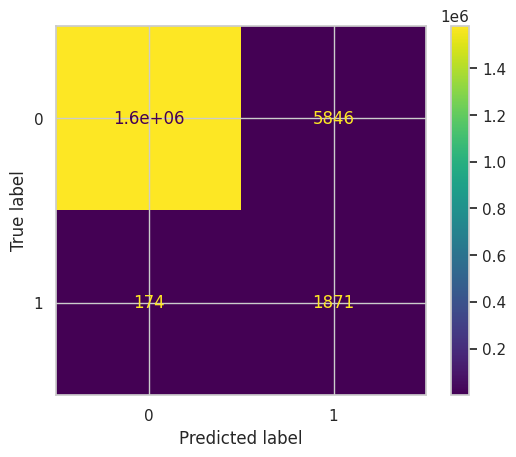

In [35]:
#confusion matrix
cm = confusion_matrix(y_test, knn_prediction, labels=knn_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot()
plt.show()

In [36]:
print(classification_report(knn_prediction, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1582938
           1       0.91      0.24      0.38      7717

    accuracy                           1.00   1590655
   macro avg       0.96      0.62      0.69   1590655
weighted avg       1.00      1.00      1.00   1590655



**7.2. Random Forests**



In [37]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf_model.fit(Xsc_train, y_train_sm)
rf_prediction = rf_model.predict(Xsc_test)
rf_prob = rf_model.predict_proba(Xsc_test)

In [38]:
list_metrics_rf = metrics_estimation(rf_model, Xsc_train, Xsc_test, y_train_sm, y_test, rf_prediction, rf_prob)

Precison score:	 0.8266159695817491
Recall score: 	 0.5315403422982885
Threshold:	 0.7590039957505685
F1 score: 0.052424
Log Loss score: 0.326328
Brier score: 0.088679


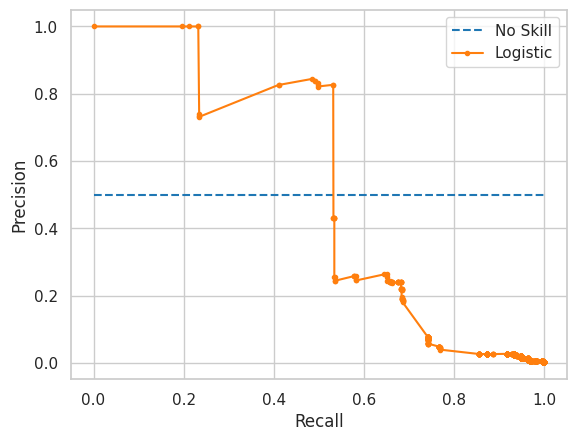

AUC PR: 0.525


In [39]:
# retrieve the probabilities for the positive class
rf_prob_positive = rf_prob[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = len((y_train_sm[y_train_sm==1])+(y_test[y_test==1])) / len(y_train_sm + y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, rf_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

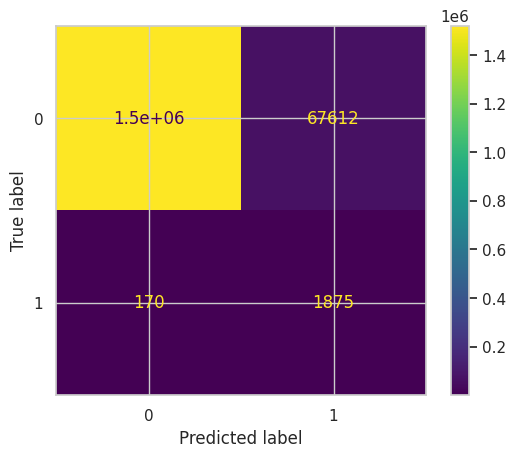

In [40]:
cm_rf = confusion_matrix(y_test, rf_prediction, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp.plot()
plt.show()

In [41]:
print(classification_report(rf_prediction, y_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98   1521168
           1       0.92      0.03      0.05     69487

    accuracy                           0.96   1590655
   macro avg       0.94      0.51      0.52   1590655
weighted avg       0.96      0.96      0.94   1590655



**7.3. Decision Tree Classifier**

In [42]:
dtc_model=DecisionTreeClassifier(random_state=42)
dtc_model.fit(Xsc_train,y_train_sm)
dtc_prediction=dtc_model.predict(Xsc_test)
dtc_prob = dtc_model.predict_proba(Xsc_test)

In [43]:
list_metrics_dtc = metrics_estimation(dtc_model, Xsc_train, Xsc_test, y_train_sm, y_test, dtc_prediction, dtc_prob)

Precison score:	 0.718012866333095
Recall score: 	 0.9823960880195599
Threshold:	 1.0
F1 score: 0.829651
Log Loss score: 0.018694
Brier score: 0.000519


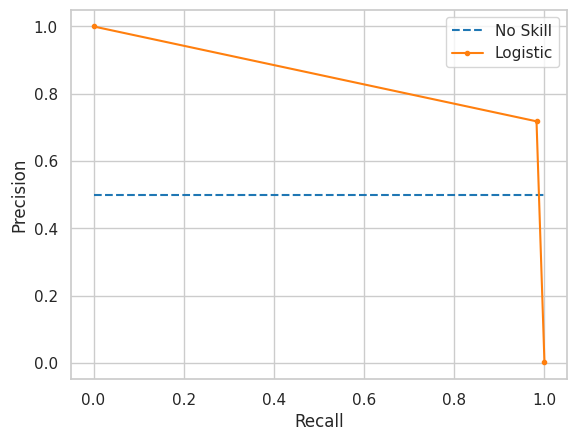

AUC PR: 0.850


In [44]:
# retrieve the probabilities for the positive class
dtc_prob_positive = dtc_prob[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = len((y_train_sm[y_train_sm==1])+(y_test[y_test==1])) / len(y_train_sm + y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, dtc_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

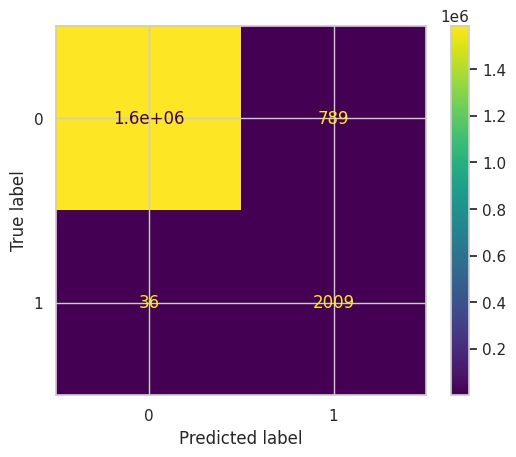

In [45]:
cm_dtc = confusion_matrix(y_test, dtc_prediction, labels=dtc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtc, display_labels=dtc_model.classes_)
disp.plot()
plt.show()

In [46]:
print(classification_report(dtc_prediction, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1587857
           1       0.98      0.72      0.83      2798

    accuracy                           1.00   1590655
   macro avg       0.99      0.86      0.91   1590655
weighted avg       1.00      1.00      1.00   1590655



**7.4. Linear Discriminant Analysis**

This method works by reducing the dimensionality of the data set by projecting all data points onto a line. It then combines these points into classes based on their distance from the center point.

This method, as you might already guess, belongs to linear classification algorithms, i.e. it is well suited for data with a linear relationship.

In [47]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(Xsc_train,y_train_sm)
lda_prediction=lda_model.predict(Xsc_test)
lda_prob = lda_model.predict_proba(Xsc_test)

In [48]:
list_metrics_lda = metrics_estimation(lda_model, Xsc_train, Xsc_test, y_train_sm, y_test, lda_prediction, lda_prob)

Precison score:	 0.6029411764705882
Recall score: 	 0.10024449877750612
Threshold:	 0.9788378435028361
F1 score: 0.009329
Log Loss score: 0.415830
Brier score: 0.144493


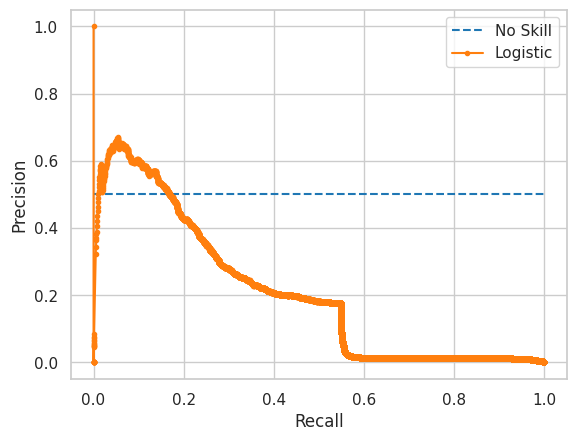

AUC PR: 0.204


In [49]:
# retrieve the probabilities for the positive class
lda_prob_positive = lda_prob[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = len((y_train_sm[y_train_sm==1])+(y_test[y_test==1])) / len(y_train_sm + y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, lda_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

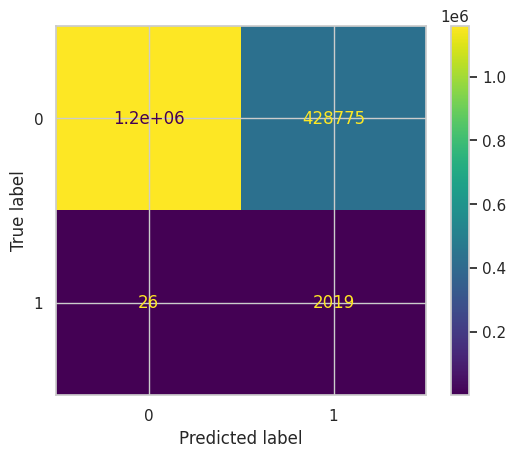

In [50]:
cm_lda = confusion_matrix(y_test, lda_prediction, labels=lda_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lda, display_labels=lda_model.classes_)
disp.plot()
plt.show()

In [51]:
print(classification_report(lda_prediction, y_test))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84   1159861
           1       0.99      0.00      0.01    430794

    accuracy                           0.73   1590655
   macro avg       0.86      0.50      0.43   1590655
weighted avg       0.80      0.73      0.62   1590655



**7.5. Logistic Regression**

Logistic regression outputs point predictions on a binary scale of zero or one. If the value of something is equal to or greater than 0.5, then the object is classified upwards (toward one). If the value is less than 0.5 - to a smaller one (towards zero).

Each feature has its own label, equal to only 0 or only 1. Logistic regression is a linear classifier and therefore is used when there is some kind of linear relationship in the data.

In [52]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(Xsc_train,y_train_sm)
lr_prediction=lr_model.predict(Xsc_test)
lr_prob = lr_model.predict_proba(Xsc_test)

In [53]:
list_metrics_lr = metrics_estimation(lr_model, Xsc_train, Xsc_test, y_train_sm, y_test, lr_prediction, lr_prob)

Precison score:	 0.601010101010101
Recall score: 	 0.523716381418093
Threshold:	 0.9992659445144876
F1 score: 0.047139
Log Loss score: 0.136757
Brier score: 0.039204


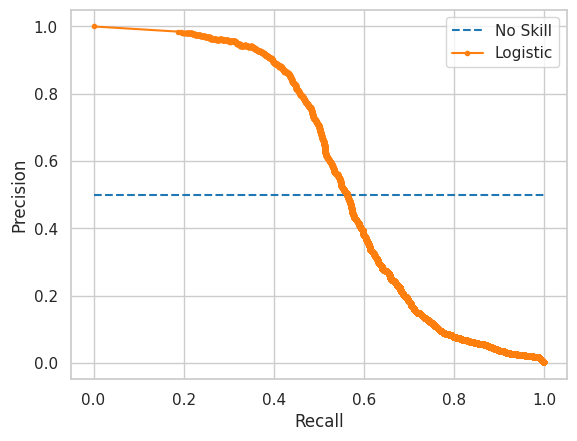

AUC PR: 0.570


In [54]:
# retrieve the probabilities for the positive class
lr_prob_positive = lr_prob[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = len((y_train_sm[y_train_sm==1])+(y_test[y_test==1])) / len(y_train_sm + y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

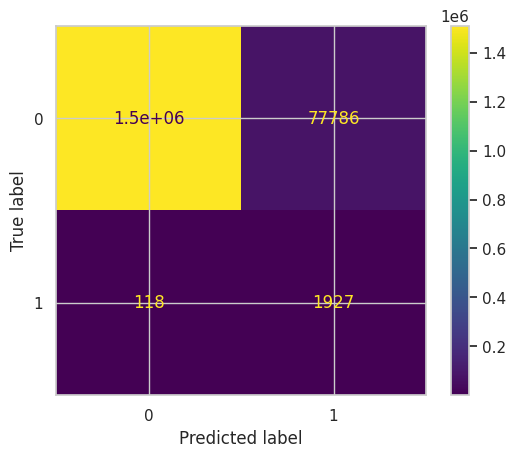

In [55]:
cm_lr = confusion_matrix(y_test, lr_prediction, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr_model.classes_)
disp.plot()
plt.show()

In [56]:
print(classification_report(lr_prediction, y_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97   1510942
           1       0.94      0.02      0.05     79713

    accuracy                           0.95   1590655
   macro avg       0.95      0.51      0.51   1590655
weighted avg       0.95      0.95      0.93   1590655



**7.6. Neural Networks**

Neural Networks are a machine learning algorithm that involves fitting many hidden layers used to represent neurons that are connected with synaptic activation functions. These essentially use a very simplified model of the brain to model and predict data.

In [57]:
nn_model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                         hidden_layer_sizes=(5, 2), random_state=1)
nn_model.fit(Xsc_train,y_train_sm)
nn_prediction = nn_model.predict(Xsc_test)
nn_prob = nn_model.predict_proba(Xsc_test)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [58]:
list_metrics_nn = metrics_estimation(nn_model, Xsc_train, Xsc_test, y_train_sm, y_test, nn_prediction, nn_prob)

Precison score:	 0.6029495178672717
Recall score: 	 0.5198044009779951
Threshold:	 0.999999999942653
F1 score: 0.099568
Log Loss score: 0.075287
Brier score: 0.016921


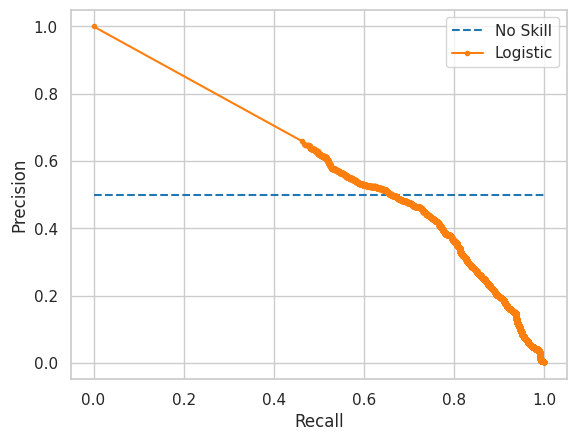

AUC PR: 0.595


In [59]:
# retrieve the probabilities for the positive class
nn_prob_positive = nn_prob[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = len((y_train_sm[y_train_sm==1])+(y_test[y_test==1])) / len(y_train_sm + y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, nn_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

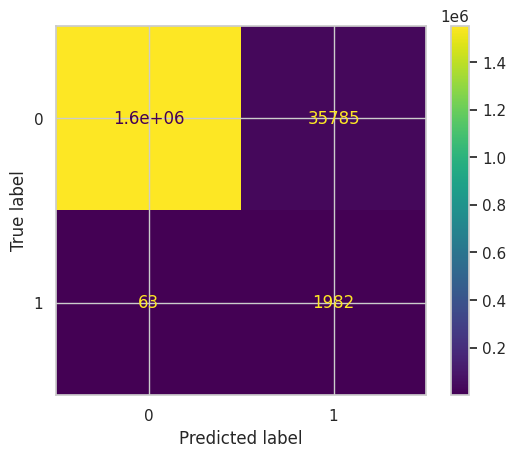

In [60]:
cm_nn = confusion_matrix(y_test, nn_prediction, labels=nn_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=nn_model.classes_)
disp.plot()
plt.show()

In [61]:
print(classification_report(nn_prediction, y_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1552888
           1       0.97      0.05      0.10     37767

    accuracy                           0.98   1590655
   macro avg       0.97      0.53      0.54   1590655
weighted avg       0.98      0.98      0.97   1590655



**7.7. XGBoost**

a type of gradient boosting algorithm that uses decision trees as its base model and is known to be one of the strongest ML algorithms for predictions

In [62]:
xgb_model = XGBClassifier(learning_rate=0.1,random_state=42)
xgb_model.fit(Xsc_train, y_train_sm)
xgb_prediction = xgb_model.predict(Xsc_test)
xgb_prob = xgb_model.predict_proba(Xsc_test)

In [63]:
list_metrics_xgb = metrics_estimation(xgb_model, Xsc_train, Xsc_test, y_train_sm, y_test, xgb_prediction, xgb_prob)

Precison score:	 0.6018575851393189
Recall score: 	 0.9506112469437653
Threshold:	 0.9518391489982605
F1 score: 0.297228
Log Loss score: 0.016114
Brier score: 0.004614


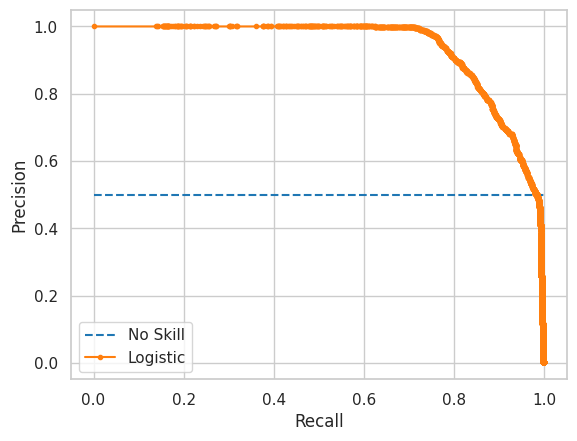

AUC PR: 0.936


In [64]:
# retrieve the probabilities for the positive class
xgb_prob_positive = xgb_prob[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = len((y_train_sm[y_train_sm==1])+(y_test[y_test==1])) / len(y_train_sm + y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, xgb_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

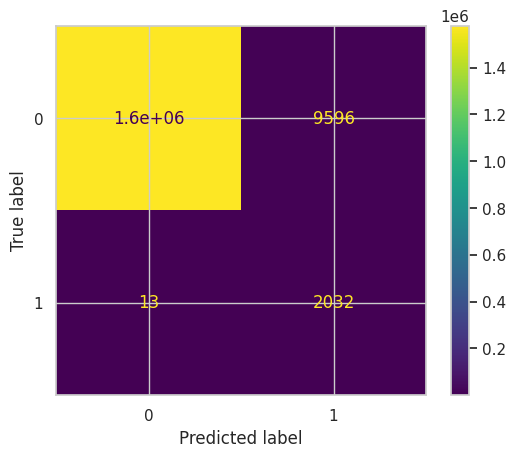

In [65]:
#confusion matrix
cm = confusion_matrix(y_test, xgb_prediction, labels=xgb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot()
plt.show()

In [66]:
print(classification_report(xgb_prediction, y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1579027
           1       0.99      0.17      0.30     11628

    accuracy                           0.99   1590655
   macro avg       0.99      0.59      0.65   1590655
weighted avg       0.99      0.99      0.99   1590655



<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

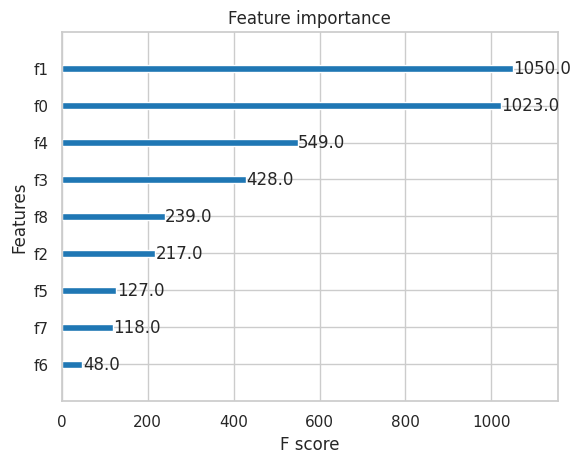

In [67]:
#The XGBoost library provides a built-in function to plot features ordered by their importance.
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb_model)

**7.8. LightGBM**

Another type of gradient boosting algorithm that is designed to be faster and more efficient than other boosting algorithms.

To date, this is the fastest method of gradient boosting, while consuming a small amount of RAM. It achieves this by building trees in depth by leaves (leaf-wise), and not by levels (level-wise), as other methods, such as XGBoost.

While XGBoost splits vertices at a whole level of the same depth at a time, LightGBM splits one vertex at a time. Hence the increase in speed.

In [68]:
lgbm_model = LGBMClassifier()
lgbm_model.fit(Xsc_train, y_train_sm)
lgbm_prediction = lgbm_model.predict(Xsc_test)
lgbm_prob = lgbm_model.predict_proba(Xsc_test)

In [69]:
list_metrics_lgbm = metrics_estimation(lgbm_model, Xsc_train, Xsc_test, y_train_sm, y_test, lgbm_prediction, lgbm_prob)

Precison score:	 0.6013451543870376
Recall score: 	 0.9618581907090464
Threshold:	 0.9744952620204488
F1 score: 0.397455
Log Loss score: 0.011473
Brier score: 0.002997


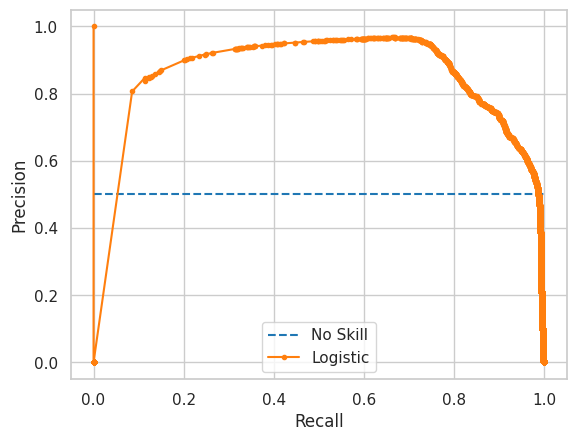

AUC PR: 0.837


In [70]:
# retrieve the probabilities for the positive class
lgbm_prob_positive = lgbm_prob[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = len((y_train_sm[y_train_sm==1])+(y_test[y_test==1])) / len(y_train_sm + y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, lgbm_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

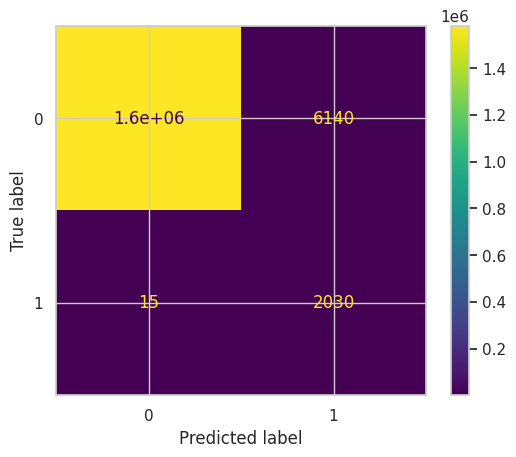

In [71]:
#confusion matrix
cm = confusion_matrix(y_test, lgbm_prediction, labels=lgbm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm_model.classes_)
disp.plot()
plt.show()

In [72]:
print(classification_report(lgbm_prediction, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1582485
           1       0.99      0.25      0.40      8170

    accuracy                           1.00   1590655
   macro avg       0.99      0.62      0.70   1590655
weighted avg       1.00      1.00      0.99   1590655



**7.9. CatBoost**

A type of gradient boosting algorithm 


In [73]:
cboost_model = CatBoostClassifier(verbose=0)
cboost_model.fit(Xsc_train, y_train_sm)
cboost_prediction = cboost_model.predict(Xsc_test)
cboost_prob = cboost_model.predict_proba(Xsc_test)

In [74]:
list_metrics_cboost = metrics_estimation(cboost_model, Xsc_train, Xsc_test, y_train_sm, y_test, cboost_prediction, cboost_prob)

Precison score:	 0.6010506798516687
Recall score: 	 0.9511002444987775
Threshold:	 0.9832536011434526
F1 score: 0.521460
Log Loss score: 0.008703
Brier score: 0.002026


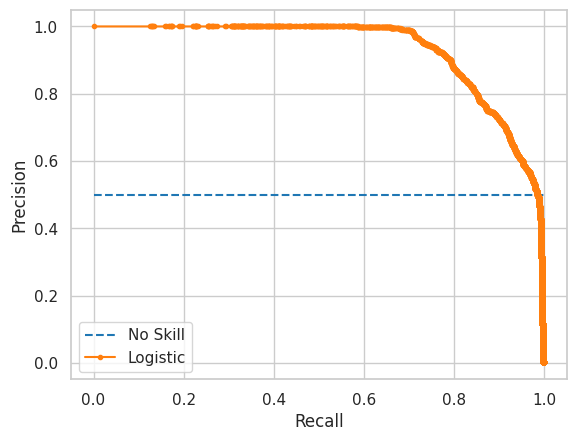

AUC PR: 0.930


In [75]:
# retrieve the probabilities for the positive class
cboost_prob_positive = cboost_prob[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = len((y_train_sm[y_train_sm==1])+(y_test[y_test==1])) / len(y_train_sm + y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, cboost_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

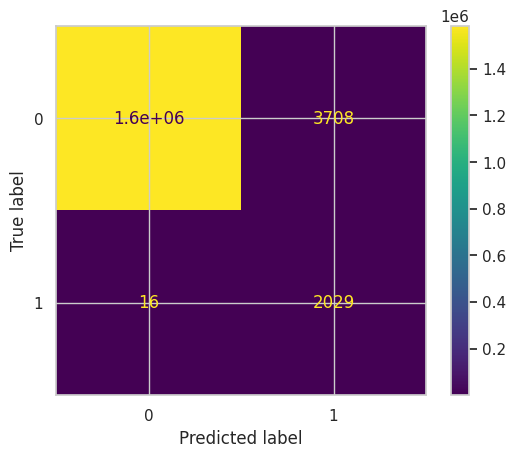

In [76]:
#confusion matrix
cm = confusion_matrix(y_test, cboost_prediction, labels=cboost_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cboost_model.classes_)
disp.plot()
plt.show()

In [77]:
print(classification_report(cboost_prediction, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1584918
           1       0.99      0.35      0.52      5737

    accuracy                           1.00   1590655
   macro avg       0.99      0.68      0.76   1590655
weighted avg       1.00      1.00      1.00   1590655



# 8. Choose Best Model

At this stage, the analysis was not carried out optimally; the dictionary could have been created at previous stages...

But it works &#128513; Let's leave improvements for the future

In [78]:
classifiers = []
classifiers.append(knn_model) #K-Nearest Neighbors
classifiers.append(rf_model) #Random Forests
classifiers.append(dtc_model) #Decision Tree Classifier
classifiers.append(lda_model) #Linear Discriminant Analysis
classifiers.append(lr_model) #Logistic Regression 
classifiers.append(nn_model) #Neural Networks
classifiers.append(xgb_model) #XGBoost
classifiers.append(lgbm_model) #LightGBM
classifiers.append(cboost_model) #CatBoost

In [79]:
precisions=[]
recalls=[]
f1s=[]
logloss=[]
briers=[]
list_metrics=[list_metrics_knn, list_metrics_rf, list_metrics_dtc, 
              list_metrics_lda, list_metrics_lr, list_metrics_nn, 
              list_metrics_xgb, list_metrics_lgbm, list_metrics_cboost]
for m in list_metrics:
    precisions.append(m[0])
    recalls.append(m[1])
    f1s.append(m[2])
    logloss.append(m[3])
    briers.append(m[4])

In [80]:
precisions_dict={}
recalls_dict={}
f1s_dict={}
logloss_dict={}
briers_dict={}

for i in range(9):
    key=['K-Nearest Neighbors', 'Random Forests', 'Decision Tree Classifier',
        'Linear Discriminant Analysis','Logistic Regression',
         'Neural Networks','XGBoost','LightGBM','CatBoost'][i]
    precisions_dict[key] = precisions[i]
    recalls_dict[key] = recalls[i]
    f1s_dict[key] = f1s[i]
    logloss_dict[key] = logloss[i]
    briers_dict[key] = briers[i]

precisions_dict_sorted = dict(sorted(precisions_dict.items(), key = lambda item: item[1]))
recalls_dict_sorted = dict(sorted(recalls_dict.items(), key = lambda item: item[1]))
f1s_dict_sorted = dict(sorted(f1s_dict.items(), key = lambda item: item[1]))
logloss_dict_sorted = dict(sorted(logloss_dict.items(), key = lambda item: item[1]))
briers_dict_sorted = dict(sorted(briers_dict.items(), key = lambda item: item[1]))

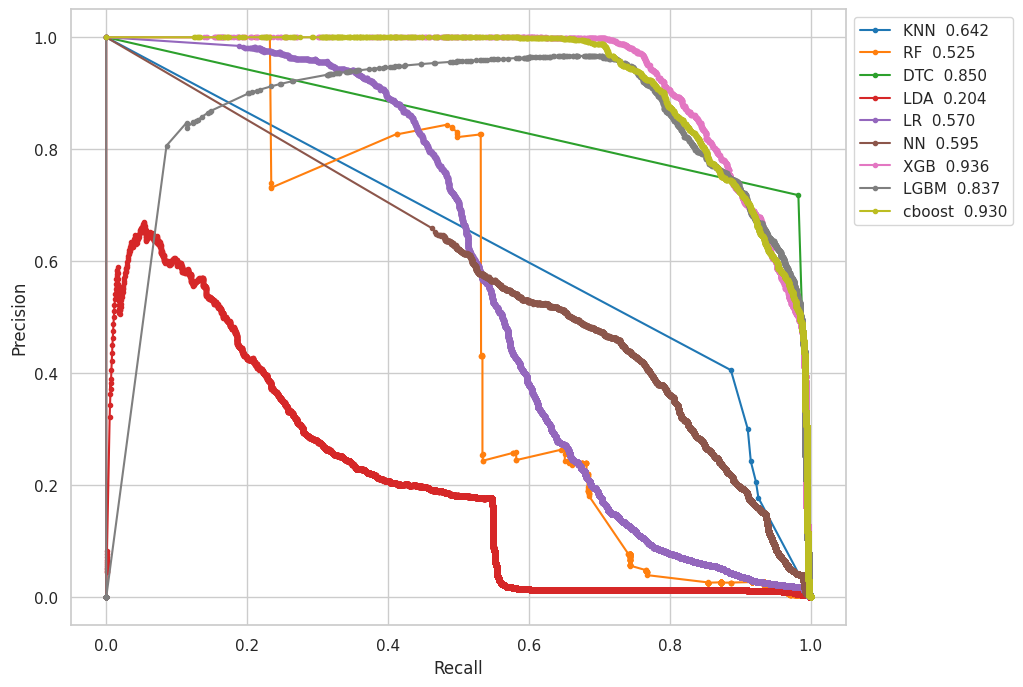

In [83]:
#set up plotting area
plt.figure(figsize=(10,8)).clf ()

#fit logistic regression model and plot ROC curve
precision, recall, thresholds = precision_recall_curve(y_test, knn_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='KNN  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(y_test, rf_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='RF  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(y_test, dtc_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='DTC  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(y_test, lda_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='LDA  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(y_test, lr_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='LR  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(y_test, nn_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='NN  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(y_test, xgb_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='XGB  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(y_test, lgbm_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='LGBM  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(y_test, cboost_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='cboost  %.3f' % auc_pr)

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend(bbox_to_anchor=(1,1))
plt.show()

for the model LDA we got strange values <0.5, but this is normal when the data is unbalanced

In [125]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],'{:.3f}'.format(y[i]))

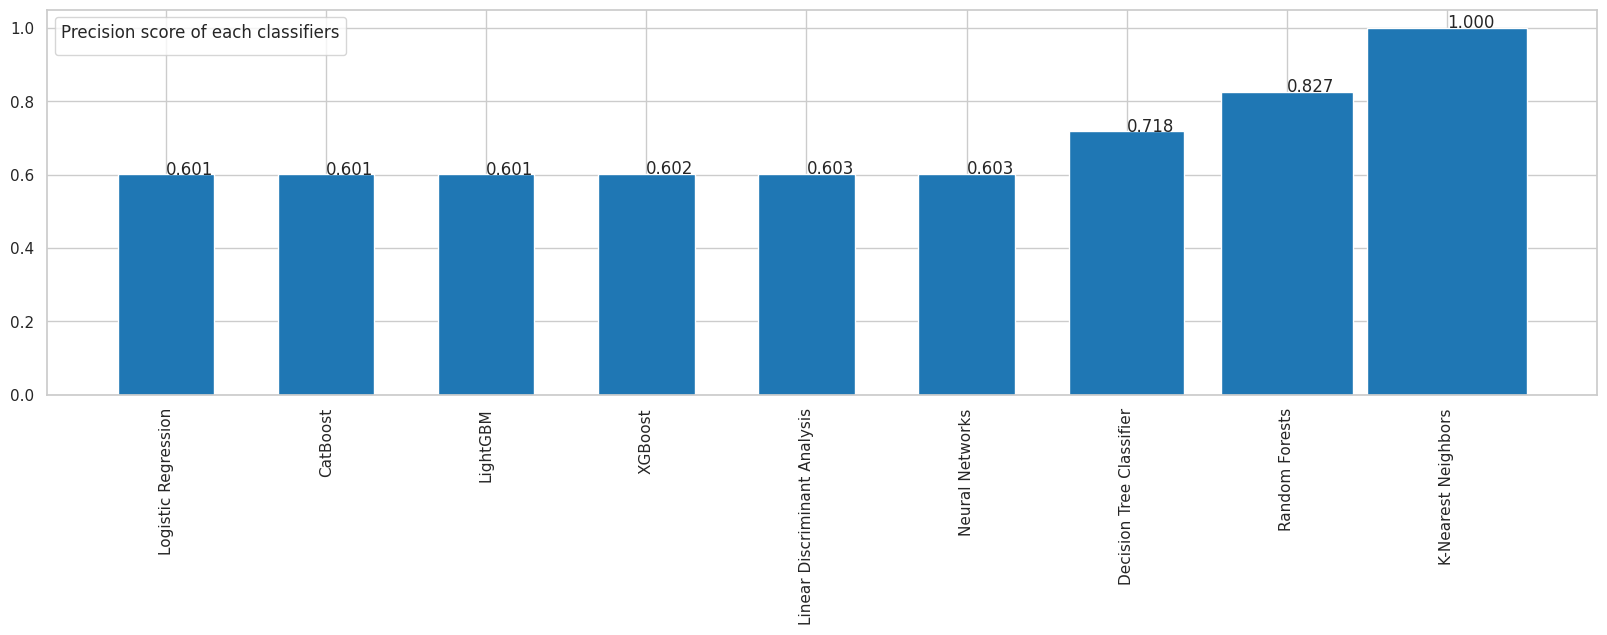

In [136]:
plt.rcParams["figure.figsize"] = (20,5)

plt.bar(list(precisions_dict_sorted.keys()), list(precisions_dict_sorted.values()), 
       np.round(list(precisions_dict_sorted.values()),3), align='center')

# calling the function to add value labels
addlabels(list(precisions_dict_sorted.keys()), list(precisions_dict_sorted.values()))

plt.legend(title='Precision score of each classifiers')
plt.xticks(rotation=90)
plt.show()

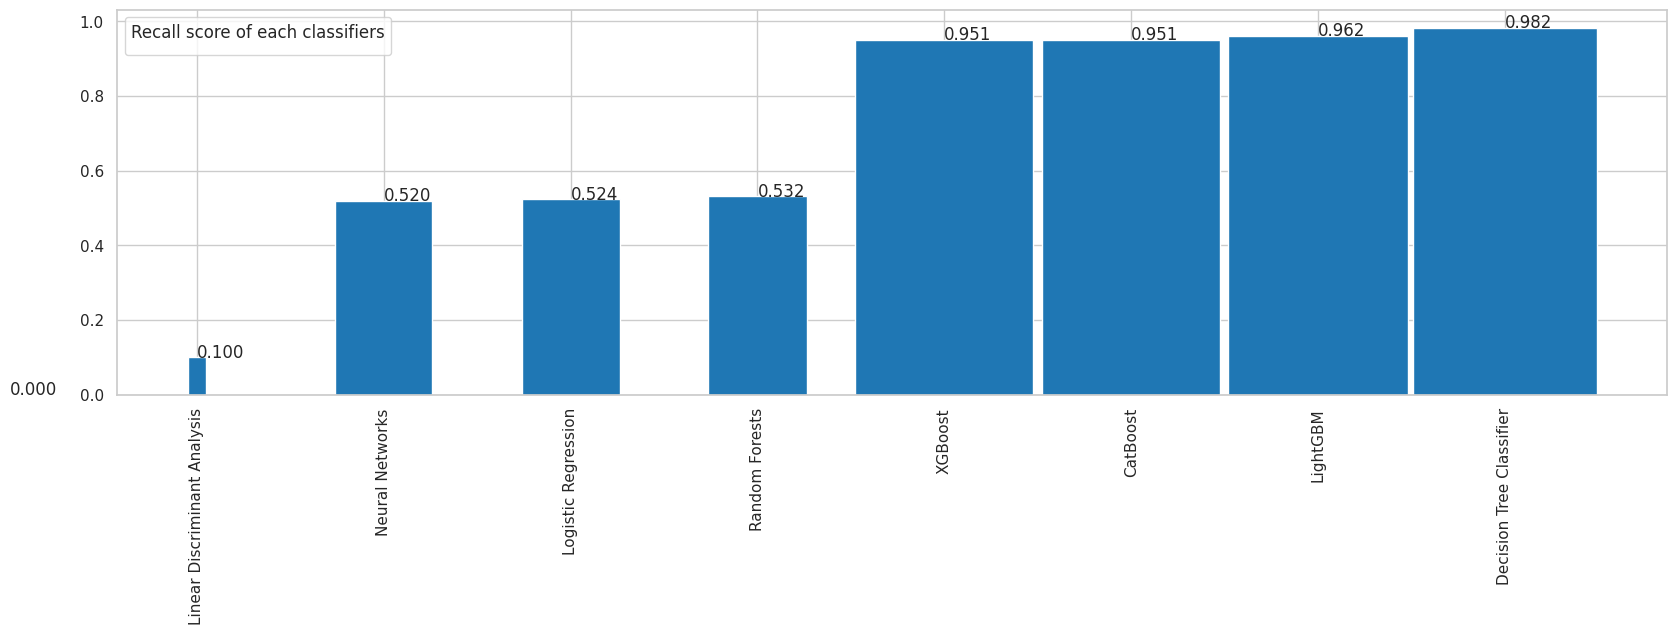

In [137]:
plt.rcParams["figure.figsize"] = (20,5)
plt.bar(list(recalls_dict_sorted.keys()), list(recalls_dict_sorted.values()), 
             np.round(list(recalls_dict_sorted.values()),3))

# calling the function to add value labels
addlabels(list(recalls_dict_sorted.keys()), list(recalls_dict_sorted.values()))

plt.legend(title='Recall score of each classifiers')
plt.xticks(rotation=90)
plt.show()

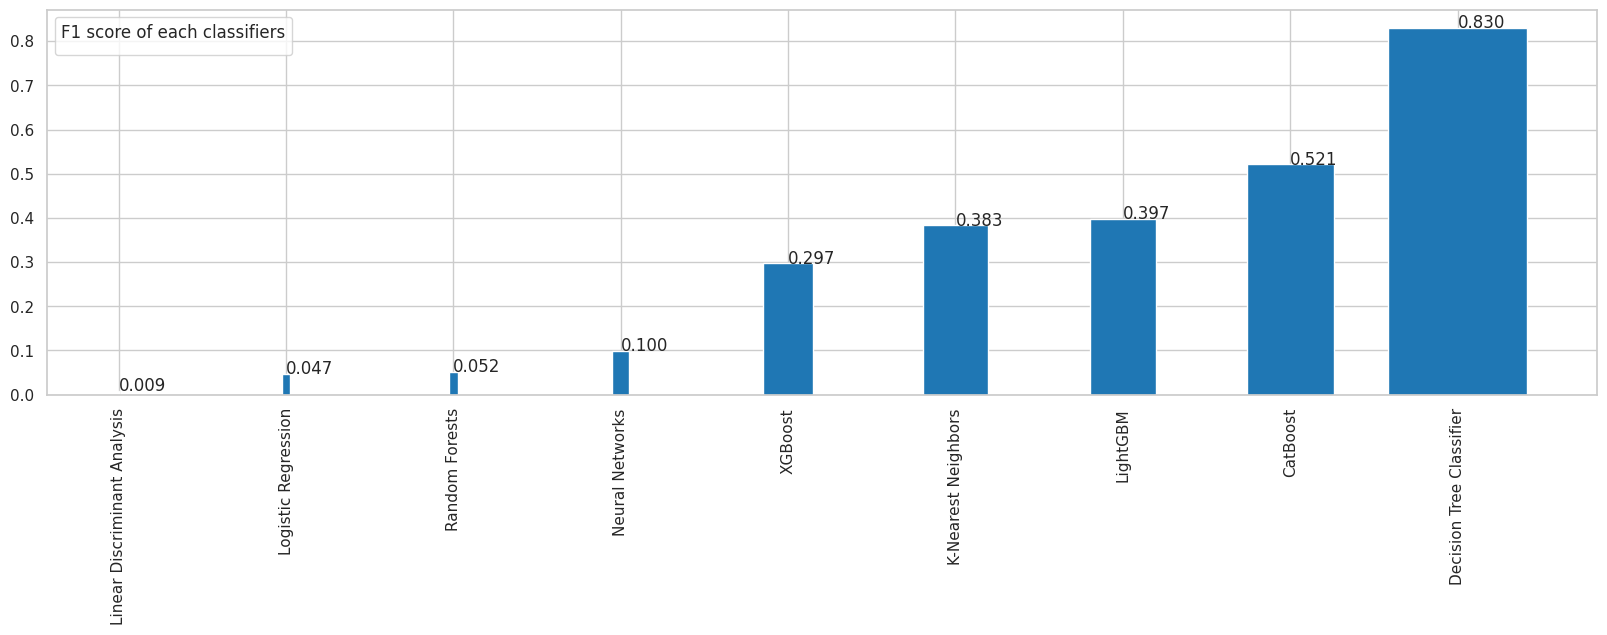

In [138]:
plt.rcParams["figure.figsize"] = (20,5)
plt.bar(list(f1s_dict_sorted.keys()), list(f1s_dict_sorted.values()), 
             np.round(list(f1s_dict_sorted.values()),3))

# calling the function to add value labels
addlabels(list(f1s_dict_sorted.keys()), list(f1s_dict_sorted.values()))

plt.legend(title='F1 score of each classifiers')
plt.xticks(rotation=90)
plt.show()

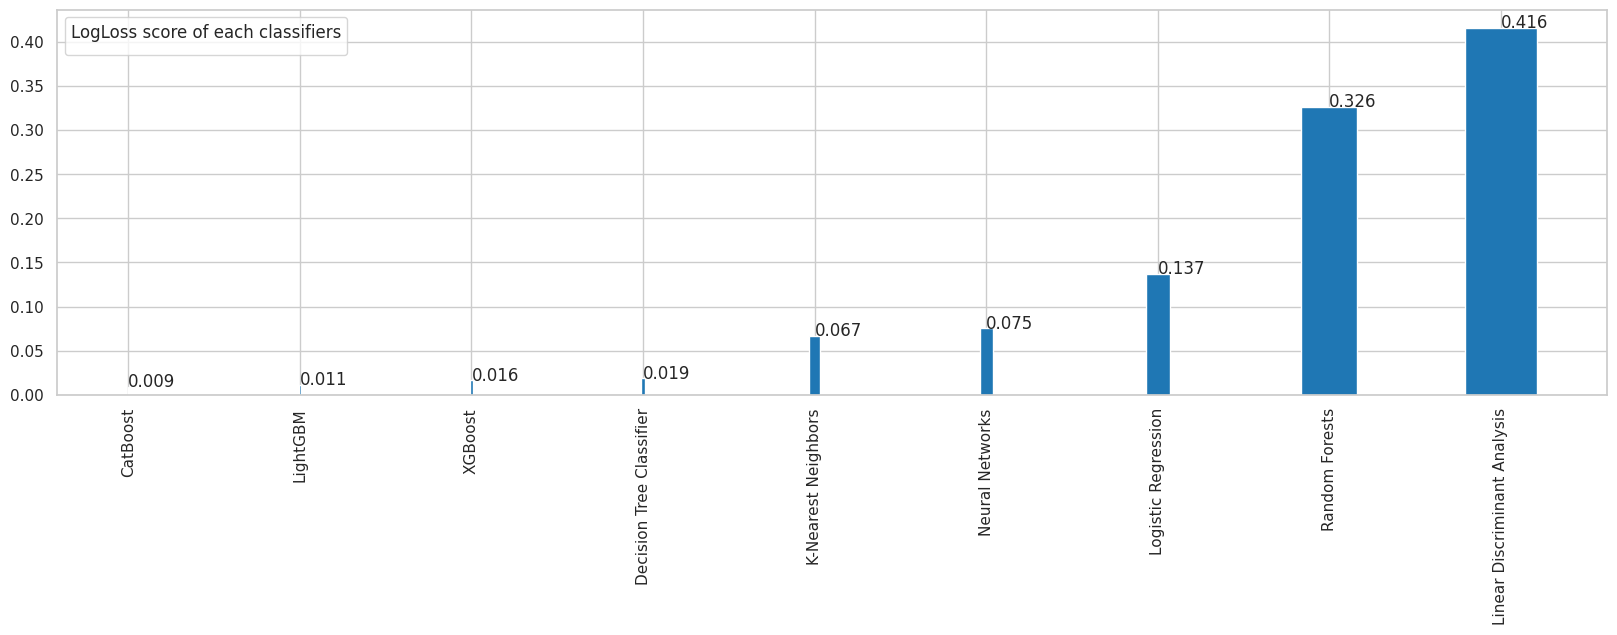

In [139]:
plt.rcParams["figure.figsize"] = (20,5)
plt.bar(list(logloss_dict_sorted.keys()), list(logloss_dict_sorted.values()), 
             np.round(list(logloss_dict_sorted.values()),3))

# calling the function to add value labels
addlabels(list(logloss_dict_sorted.keys()), list(logloss_dict_sorted.values()))

plt.legend(title='LogLoss score of each classifiers')
plt.xticks(rotation=90)
plt.show()

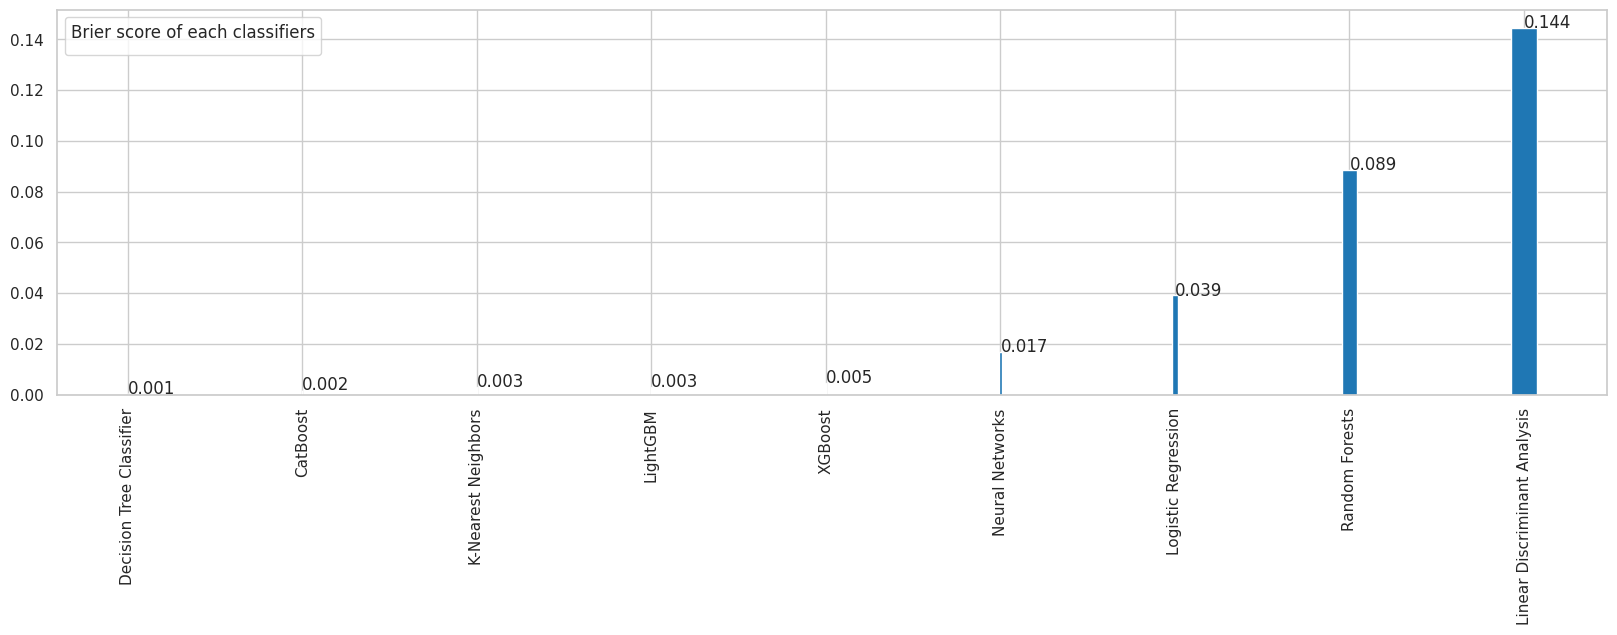

In [141]:
plt.rcParams["figure.figsize"] = (20,5)
plt.bar(list(briers_dict_sorted.keys()), list(briers_dict_sorted.values()), 
             np.round(list(briers_dict_sorted.values()),3))

# calling the function to add value labels
addlabels(list(briers_dict_sorted.keys()), list(briers_dict_sorted.values()))

plt.legend(title='Brier score of each classifiers')
plt.xticks(rotation=90)
plt.show()

Several models (CatBoost,LightGBM,XGBoost)coped well with their task and it’s hard to choose just one since they are not optimized. Perhaps after GridSearchCV, that is, searching for the best parameters, one of them will perform much better...